# Q1

Data Shape: (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.05

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Posterior Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0] -0.604  0.122  -0.830   -0.382      0.002    0.003    2701.0   
betas[1] -1.122  0.163  -1.408   -0.799      0.003    0.004    2284.0   
betas[2] -1.312  0.121  -1.536   -1.086      0.002    0.003    2598.0   
betas[3] -0.555  0.135  -0.809   -0.300      0.003    0.003    2390.0   
betas[4] -0.331  0.137  -0.583   -0.075      0.003    0.004    2603.0   
betas[5] -0.012  0.125  -0.234    0.230      0.003    0.003    2421.0   
betas[6] -0.012  0.183  -0.330    0.356      0.004    0.004    2101.0   
betas[7] -0.091  0.120  -0.308    0.144      0.002    0.003    3032.0   

          ess_tail  r_hat  
betas[0]    1556.0   1.00  
betas[1]    1658.0   1.00  
betas[2]    1560.0   1.01  
betas[3]    1584.0   1.00  
betas[4]    1039.0   1.00  
betas[5]    1491.0   1.00  
betas[6]    1481.0   1.00  
betas[7]    1460.0   1.00  

Test Accuracy: 0.8112


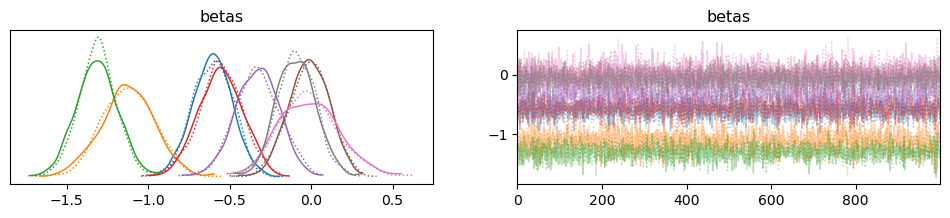

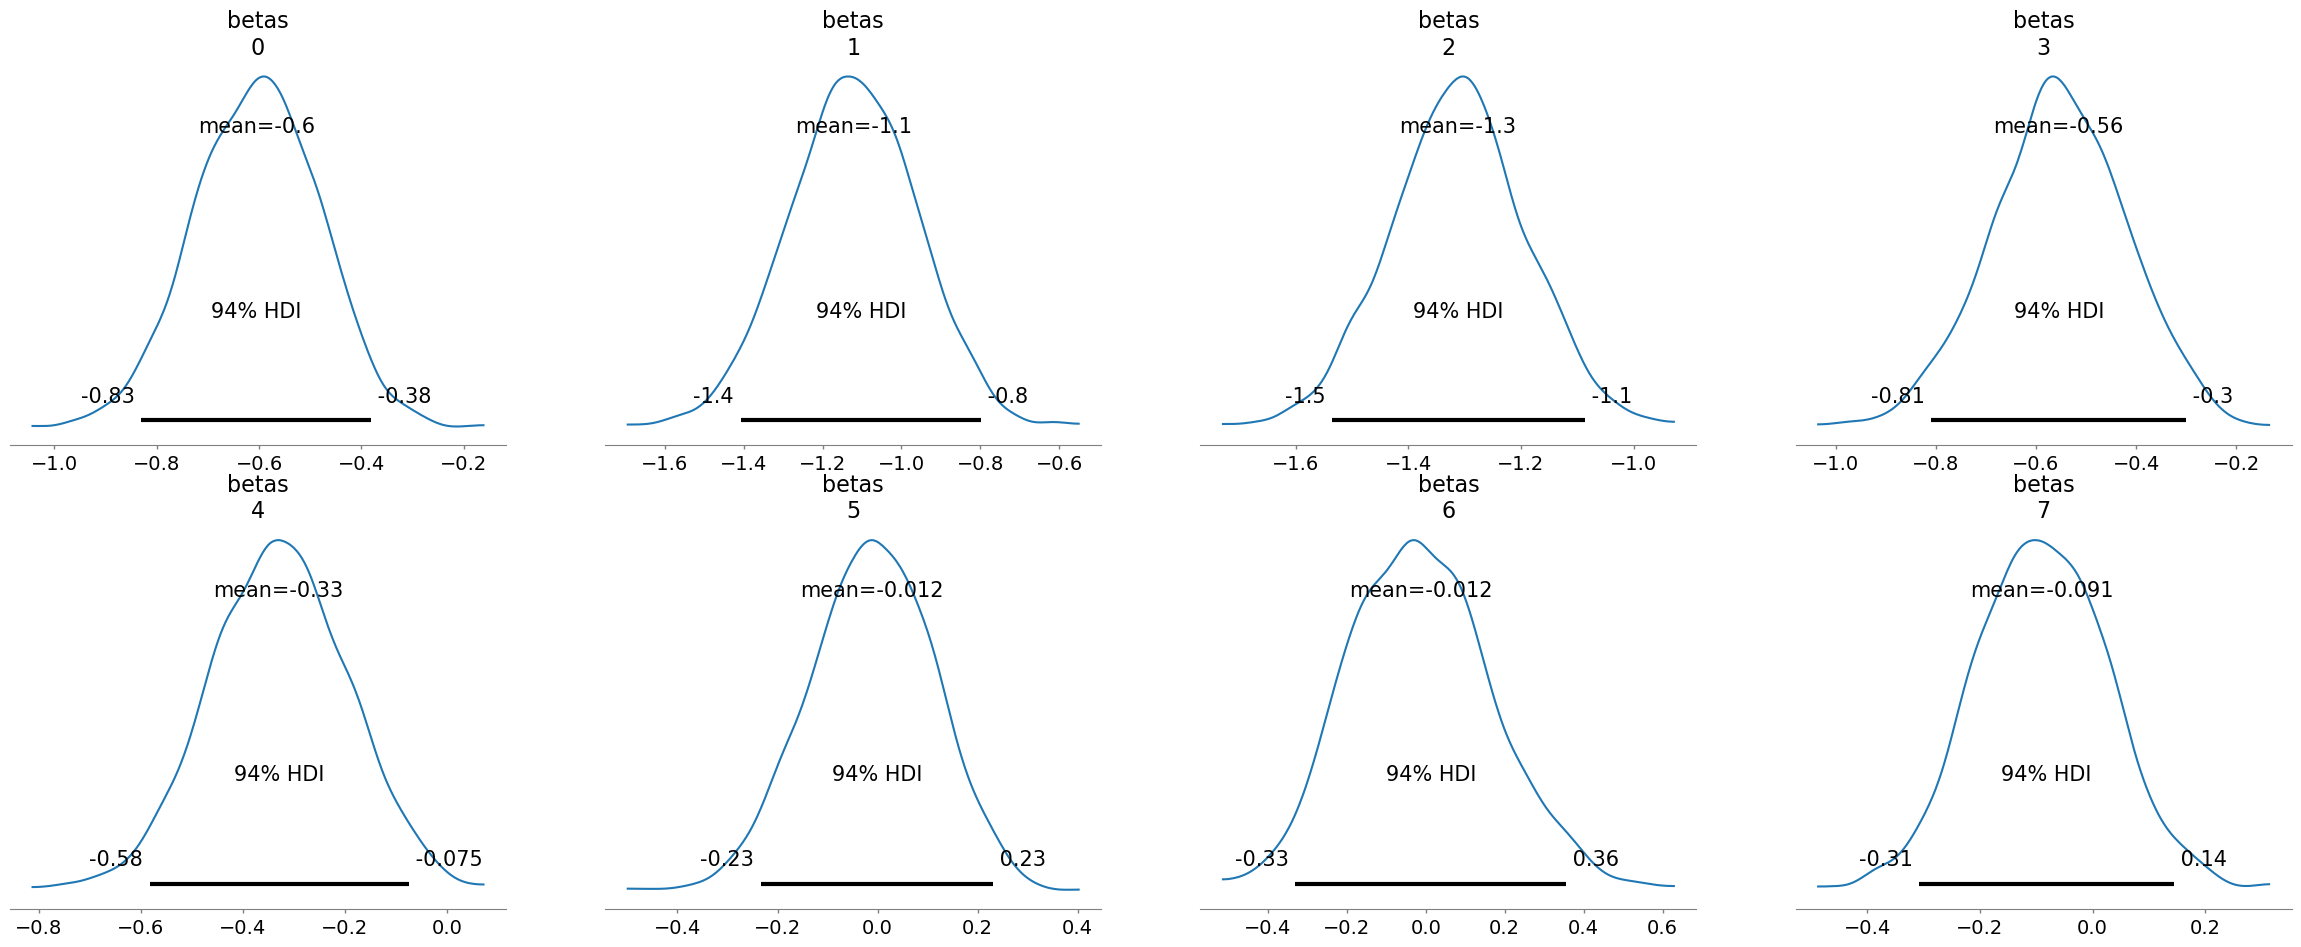

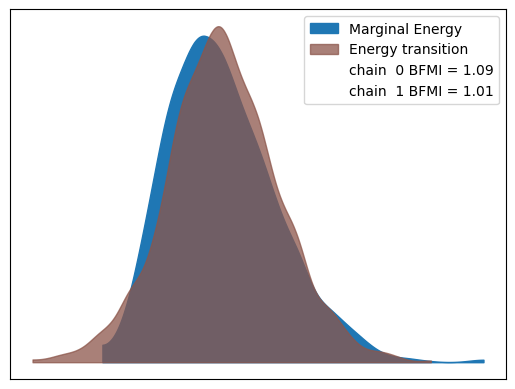

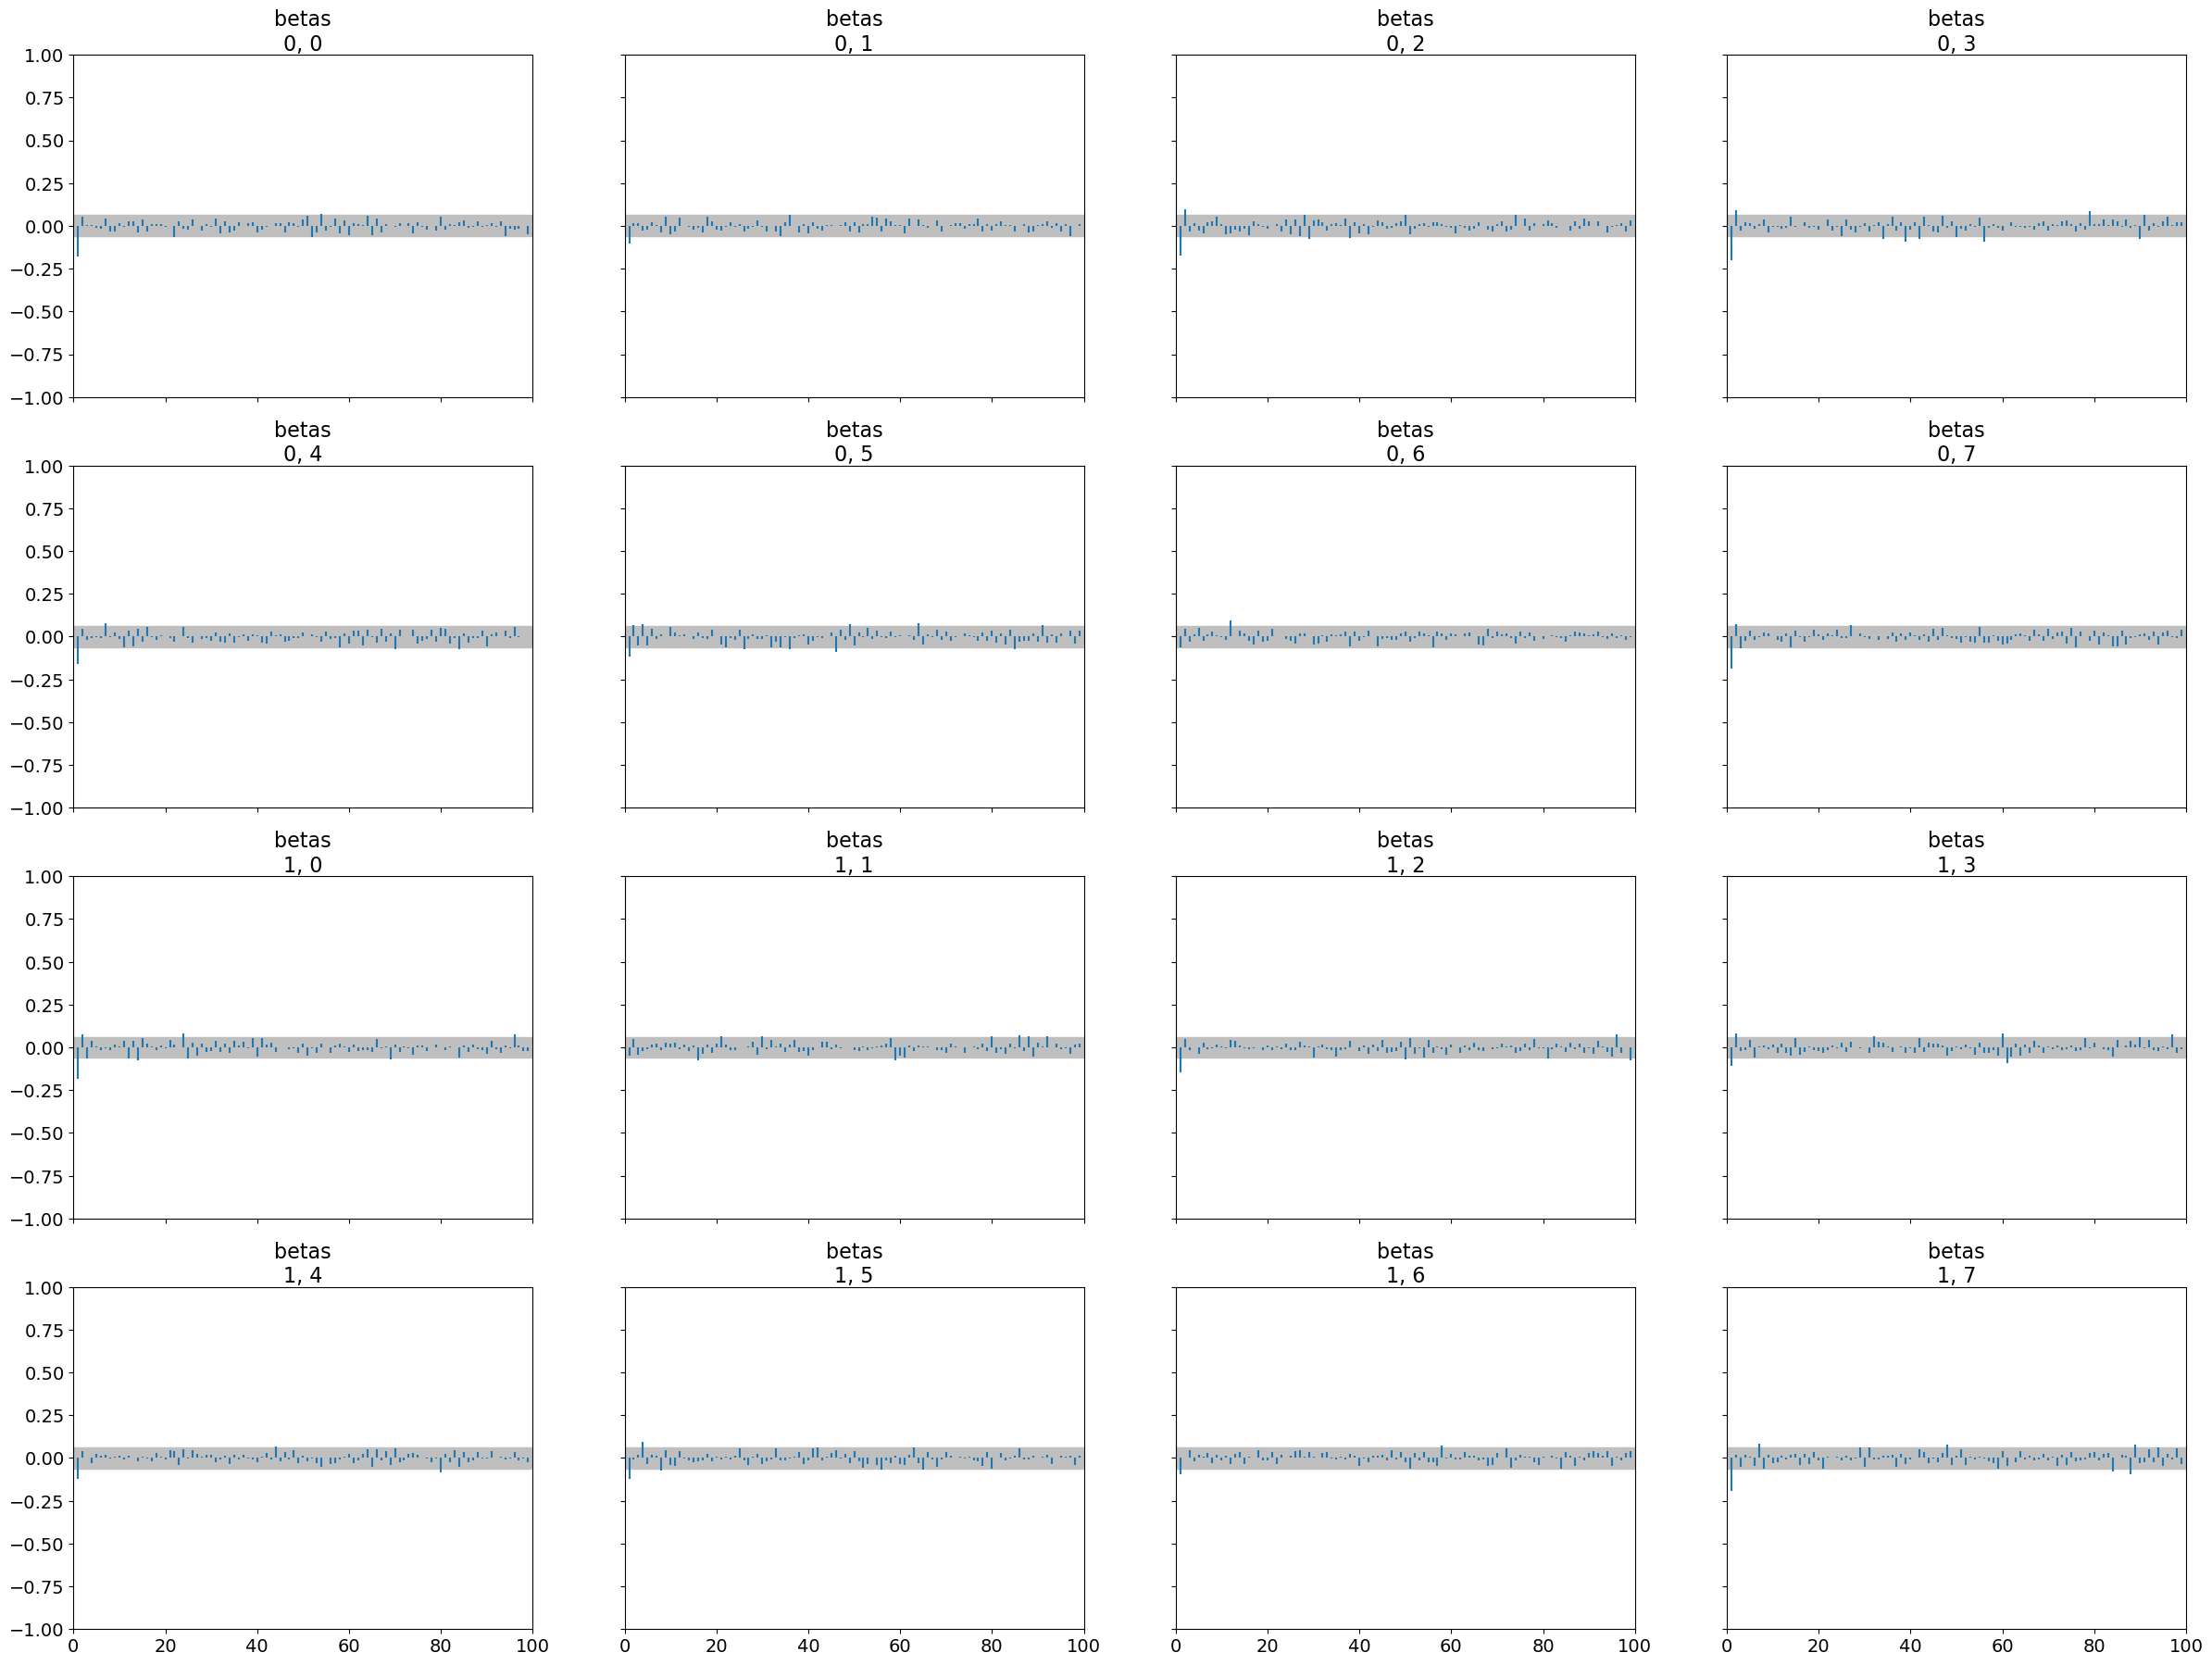

In [4]:
import pandas as pd
import numpy as np
import pymc as pm       
import arviz as az
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. Load Titanic dataset (train.csv)
titanic_df = pd.read_csv('titanic.csv')
print("Data Shape:", titanic_df.shape)
print(titanic_df.head())

# 2. Data Cleaning & Preprocessing
cols_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
titanic_df.drop(columns=cols_to_drop, inplace=True)

# Drop rows missing key values
titanic_df.dropna(subset=["Age", "Embarked"], inplace=True)

# Encode categorical columns
cat_cols = ["Sex", "Embarked"]
for col in cat_cols:
    le = LabelEncoder()
    titanic_df[col] = le.fit_transform(titanic_df[col])

# 3. Define features & target
target_col = "Survived"
X = titanic_df.drop(columns=[target_col])
y = titanic_df[target_col]

# Standardize numeric columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 4. Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Training set shape:", X_train.shape)
print("Test set shape:    ", X_test.shape)

# 5. Build Bayesian Logistic Regression Model
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# Add intercept term
X_train_np = np.concatenate([np.ones((X_train_np.shape[0], 1)), X_train_np], axis=1)
X_test_np = np.concatenate([np.ones((X_test_np.shape[0], 1)), X_test_np], axis=1)

n_features = X_train_np.shape[1]

with pm.Model() as logistic_model:
    # Priors for coefficients
    betas = pm.Normal("betas", mu=0, sigma=1, shape=n_features)
    
    # Linear predictor
    z = pm.math.dot(X_train_np, betas)
    
    # Sigmoid link
    theta = pm.math.sigmoid(z)
    
    # Bernoulli likelihood
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y_train)
    
    # Draw posterior samples
    trace = pm.sample(
        draws=1000,
        tune=1000,
        cores=2,
        random_seed=42,
        return_inferencedata=True
    )

# 6. Posterior Analysis & Diagnostics
summary = az.summary(trace)
print("\nPosterior Summary:\n", summary)

az.plot_trace(trace)
az.plot_posterior(trace)
az.plot_energy(trace)
az.plot_autocorr(trace)

# 7. Predictions on test set & accuracy
beta_mean = trace.posterior["betas"].mean(dim=["chain","draw"]).values

z_test = np.dot(X_test_np, beta_mean)
pred_prob = 1 / (1 + np.exp(-z_test))
y_pred = (pred_prob >= 0.5).astype(int)

accuracy = np.mean(y_pred == y_test.values)
print(f"\nTest Accuracy: {accuracy:.4f}")

## Explanation of the Results

1. **Posterior Summary and Coefficients**  
   - The `betas` in the posterior summary represent each feature’s regression coefficient.  
   - A positive coefficient indicates a higher log-odds (and thus a higher probability) of survival, while a negative coefficient indicates a lower log-odds of survival.  
   - The magnitude of each coefficient reflects how strongly that feature influences survival in the model.

2. **MCMC Diagnostics**  
   - The trace plots, posterior plots, and autocorrelation plots help ensure that our Markov chain has converged.  
   - If the chains are mixing well and the R-hat (Gelman-Rubin statistic) is near 1.0, we can be more confident in the reliability of our posterior estimates.

3. **Test Accuracy**  
   - The accuracy on the test set indicates how well the model generalizes.  
   - While accuracy is a straightforward metric, deeper insights can be gained by examining precision, recall, or AUC (Area Under the Curve).  
   - By evaluating additional metrics, we can better understand the model’s performance and whether it is well-calibrated for real-world predictions.

# Q2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2356 seconds.


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'packed_L'}>,
        <Axes: title={'center': 'packed_L'}>]], dtype=object)

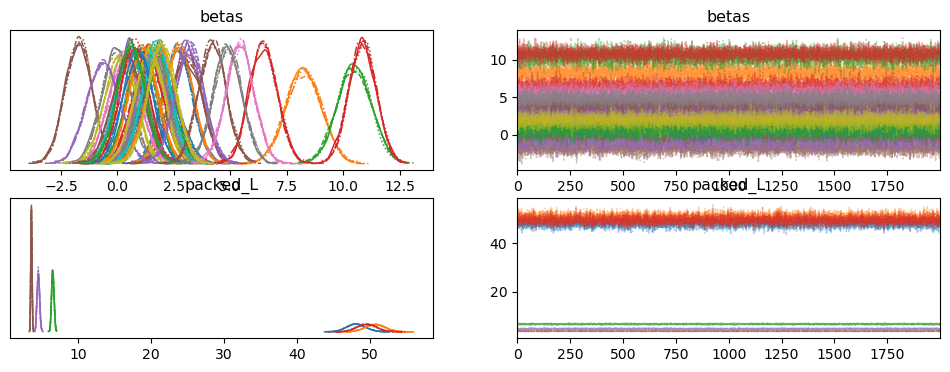

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

# 1. Load the dataset
#    Make sure you have downloaded "StudentsPerformance.csv" from:
#    https://www.kaggle.com/datasets/spscientist/students-performance-in-exams

data = pd.read_csv("StudentsPerformance.csv")
data = data.dropna()  # Drop any rows with missing values if present

# 2. One-hot encode (get dummies) for categorical variables
#    We exclude the three continuous outcome variables (scores) from the drop
categorical_cols = ["gender", "race/ethnicity", "parental level of education",
                    "lunch", "test preparation course"]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 3. Separate the outcomes (Y) and predictors (X)
#    We have three continuous outcomes (multivariate): math, reading, writing
Y = data[["math score", "reading score", "writing score"]].values

#    Now drop them from the dataframe so we can define X
X_df = data.drop(["math score", "reading score", "writing score"], axis=1)

# 4. Add an intercept column to X
ones = np.ones(shape=(X_df.shape[0], 1))
X = np.concatenate([ones, X_df.values], axis=1)

# 5. Define dimensions
n, p = X.shape  # n samples, p predictors (including intercept)
m = Y.shape[1]  # m=3 outcome variables

# 6. Build the Bayesian model in PyMC
with pm.Model() as multivar_model:
    # (a) Priors for regression coefficients: shape=(p, m)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    
    # (b) LKJCholeskyCov for the covariance structure among the 3 outcomes
    packed_L = pm.LKJCholeskyCov(
        "packed_L",
        n=m,
        eta=2.0,  # Slight shrinkage towards zero correlation
        sd_dist=pm.Exponential.dist(1.0, shape=m),
        compute_corr=False
    )
    L = pm.expand_packed_triangular(m, packed_L)
    
    # (c) Mean structure
    mu = pm.math.dot(X, betas)
    
    # (d) Likelihood: multivariate normal with Cholesky factor
    y_obs = pm.MvNormal("y_obs", mu=mu, chol=L, observed=Y)
    
    # (e) MCMC sampling
    trace = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.9,
        chains=4,
        random_seed=42
    )

# 7. Posterior analysis & diagnostics
az.plot_trace(trace, var_names=["betas", "packed_L"])

## Explanation

1. **Data Preparation**
   - We use the **Students Performance in Exams** dataset, which has three exam scores: `math score`, `reading score`, and `writing score`. These form our **multivariate response** (shape: \((n, 3)\)).  
   - We create dummy (one-hot) variables for categorical predictors like `gender`, `race/ethnicity`, etc. An intercept column is added to handle a baseline level.

2. **Model Structure**
   - The regression coefficients \(\beta\) have shape \((p,m)\): we have \(p\) predictors (including intercept) and \(m = 3\) outcome dimensions.  
   - We use **LKJCholeskyCov** (`packed_L`) to model the covariance among the three outcome variables.  
   - The linear predictor is \(\mu = X \times \beta\).

3. **MCMC Sampling**
   - We employ PyMC’s **No-U-Turn Sampler (NUTS)** to draw samples. We specify `draws=2000` total samples after `tune=1000` warm-up iterations and choose `target_accept=0.9` for a more robust acceptance criterion.

4. **Results & Diagnostics**
   - `arviz.plot_trace` helps visualize the posterior distribution for the coefficients (`betas`) and the Cholesky factor (`packed_L`).  
   - If trace plots show good mixing and no major divergences, we can conclude the chains have likely converged.  
   - The posterior distributions reveal both the estimated regression coefficients for each predictor-outcome pair and the correlation/variance structure among the multiple outcomes.


# Q3

Dataset Head:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN

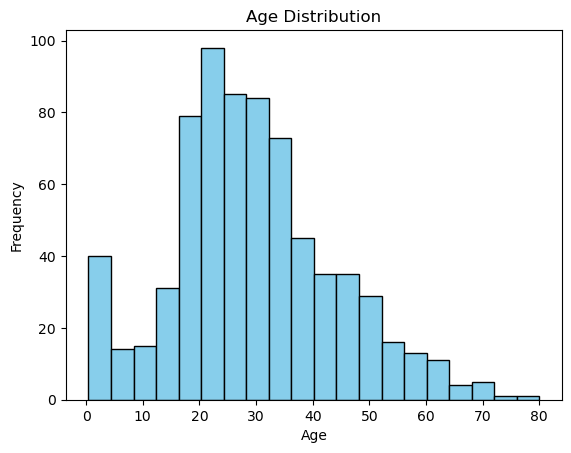

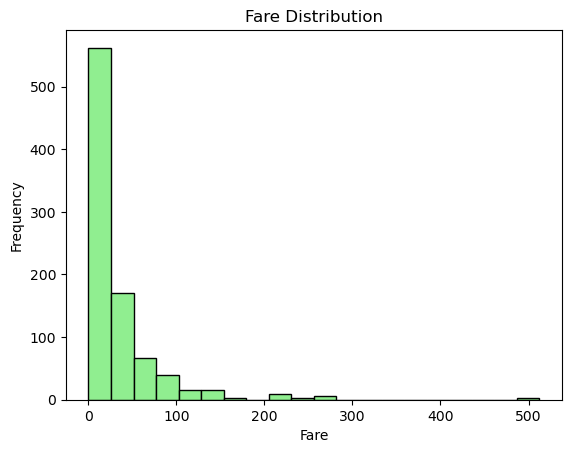

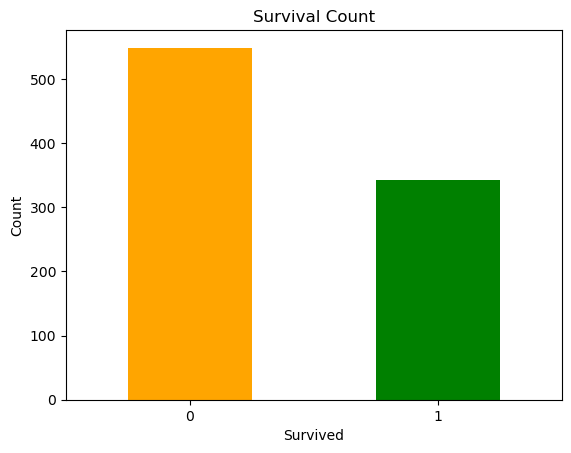

Sampling: [beta, y_obs]



Standardized Feature Summary:
             Pclass           Sex           Age          Fare    FamilySize
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02
mean  -8.772133e-17  3.987333e-17  2.272780e-16  3.987333e-18 -2.392400e-17
std    1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00
min   -1.566107e+00 -7.376951e-01 -2.224156e+00 -6.484217e-01 -5.609748e-01
25%   -3.693648e-01 -7.376951e-01 -5.657365e-01 -4.891482e-01 -5.609748e-01
50%    8.273772e-01 -7.376951e-01 -1.046374e-01 -3.573909e-01 -5.609748e-01
75%    8.273772e-01  1.355574e+00  4.333115e-01 -2.424635e-02  5.915988e-02
max    8.273772e-01  1.355574e+00  3.891554e+00  9.667167e+00  5.640372e+00


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y_obs]


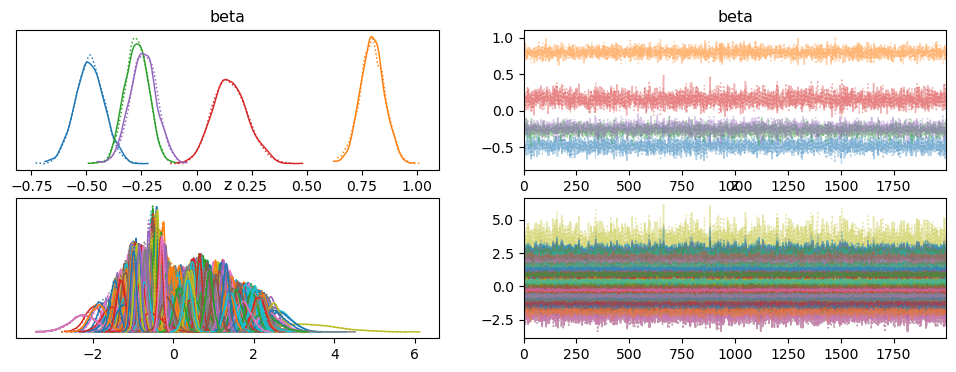


Posterior Summary Statistics:
         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0] -0.49  0.07   -0.61    -0.36        0.0      0.0   3505.13   2933.23   
beta[1]  0.80  0.06    0.70     0.91        0.0      0.0   3949.18   2791.30   
beta[2] -0.27  0.05   -0.38    -0.18        0.0      0.0   3485.49   2392.14   
beta[3]  0.15  0.08    0.01     0.30        0.0      0.0   3586.45   3076.02   
beta[4] -0.24  0.06   -0.35    -0.12        0.0      0.0   3793.06   2868.10   
...       ...   ...     ...      ...        ...      ...       ...       ...   
z[886]  -0.28  0.06   -0.40    -0.17        0.0      0.0   3713.80   2650.94   
z[887]   2.19  0.16    1.89     2.51        0.0      0.0   3471.36   2718.67   
z[888]   0.37  0.09    0.19     0.54        0.0      0.0   4825.81   3257.59   
z[889]   0.37  0.11    0.16     0.57        0.0      0.0   3655.59   2869.06   
z[890]  -0.98  0.07   -1.12    -0.86        0.0      0.0   4448.11   3311.16   

        

ValueError: Found input variables with inconsistent numbers of samples: [891, 2000]

In [16]:
    # ---------------------------
    # 1. Data Loading and Exploration
    # ---------------------------
    df = pd.read_csv('titanic.csv')  # Titanic dataset: https://www.kaggle.com/c/titanic/data
    # Typically, df has 891 rows

    print("Dataset Head:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())

    # Quick plots: Age, Fare, Survived
    plt.figure()
    plt.hist(df['Age'].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure()
    plt.hist(df['Fare'].dropna(), bins=20, color='lightgreen', edgecolor='black')
    plt.title('Fare Distribution')
    plt.xlabel('Fare')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure()
    df['Survived'].value_counts().plot(kind='bar', color=['orange', 'green'])
    plt.title('Survival Count')
    plt.xlabel('Survived')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

    # ---------------------------
    # 2. Data Preprocessing & Feature Engineering
    # ---------------------------
    # Fill missing values
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # Encode Sex: female=1, male=0
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})

    # Create a new feature: FamilySize = SibSp + Parch + 1
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Select features and target
    features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize']
    target = 'Survived'
    X = df[features].values  # shape: (891, 5)
    y = df[target].values    # shape: (891,)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print("\nStandardized Feature Summary:")
    print(pd.DataFrame(X_scaled, columns=features).describe())

    # ---------------------------
    # 3. Bayesian Probit Regression Model
    # ---------------------------
    with pm.Model() as model:
        # Coefficients: beta ~ Normal(0,1)
        beta = pm.Normal('beta', mu=0, sigma=1, shape=X_scaled.shape[1])

        # Linear predictor
        z = pm.Deterministic('z', pm.math.dot(X_scaled, beta))

        # Inverse probit link
        p_surv = pm.math.invprobit(z)

        # Observed Bernoulli outcome
        y_obs = pm.Bernoulli('y_obs', p=p_surv, observed=y)

        # Optional: sample from the prior
        prior_pred = pm.sample_prior_predictive(samples=300)

        # MCMC sampling
        trace = pm.sample(draws=2000, tune=1000, target_accept=0.9, random_seed=42, chains=2)

        # Posterior predictive (return_inferencedata=False => dictionary)
        ppc = pm.sample_posterior_predictive(trace, return_inferencedata=False)

    # ---------------------------
    # 4. Diagnostics & Posterior Analysis
    # ---------------------------
    az.plot_trace(trace)
    plt.show()

    print("\nPosterior Summary Statistics:")
    print(az.summary(trace, round_to=2))

    # ---------------------------
    # 5. Posterior Predictive Checks & Model Evaluation
    # ---------------------------
    # ppc['y_obs'] shape => (n_draws, n_observations) e.g. (2000, 891)
    # We want a single prediction array of shape (891,). We take the mean across draws:
    y_pred_prob = ppc['y_obs'].mean(axis=0)  # shape => (891,)
    y_pred = (y_pred_prob > 0.5).astype(int) # shape => (891,)

    # Now shapes match: y (891,) vs. y_pred (891,)
    print("\nChecking shapes:")
    print("y shape:", y.shape)
    print("y_pred shape:", y_pred.shape)

    # Accuracy & confusion matrix
    accuracy = accuracy_score(y, y_pred)
    cmatrix = confusion_matrix(y, y_pred)
    print("\nModel Accuracy:", accuracy)
    print("Confusion Matrix:\n", cmatrix)

    # Plot posterior predictive probability distribution
    plt.figure()
    plt.hist(y_pred_prob, bins=20, color='purple', edgecolor='black')
    plt.title('Posterior Predictive Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.show()

    # Compare predicted vs actual
    plt.figure()
    plt.bar(['Pred Survived', 'Pred Not Survived'], [y_pred.sum(), len(y_pred) - y_pred.sum()],
            color=['green', 'red'])
    plt.title('Counts of Predicted Classes')
    plt.show()

    plt.figure()
    plt.bar(['Actual Survived', 'Actual Not Survived'], [y.sum(), len(y) - y.sum()],
            color=['green', 'red'])
    plt.title('Counts of Actual Classes')
    plt.show()

    # Optional: Posterior Predictive Check Plot
    ppc_idata = az.from_dict(
        posterior_predictive=ppc, 
        coords={"obs_id": np.arange(len(y))}, 
        dims={"y_obs": ["obs_id"]}
    )
    az.plot_ppc(ppc_idata, group="posterior_predictive", data_pairs={"y_obs": "y_obs"})
    plt.show()

### Explanation of the Results for the Enriched Titanic Dataset Analysis

1. **Exploratory Data Analysis (EDA)**:
   - The dataset is initially explored with summary statistics and visualizations. Histograms for the `Age` and `Fare` columns reveal 
     their distributions, while a bar chart of the `Survived` column shows the imbalance between survivors and non-survivors.
   - These plots help in understanding the data characteristics and guide preprocessing steps.

2. **Data Preprocessing and Feature Engineering**:
   - Missing values in critical features (`Age` and `Fare`) are imputed using the median.
   - The categorical feature `Sex` is encoded into a binary format.
   - A new feature `FamilySize` (calculated as `SibSp + Parch + 1`) is added, which can provide additional insight into survival chances.
   - Features are standardized to improve the stability of the Bayesian inference.

3. **Bayesian Probit Regression Model**:
   - The model uses a latent variable formulation where the linear combination of features (using regression coefficients `beta`) 
     is linked to the survival probability via the inverse probit function.
   - Regression coefficients are assigned a Normal(0, 1) prior, reflecting initial uncertainty.
   - MCMC sampling (with increased iterations) is employed to robustly estimate the posterior distributions of the parameters.
   - Trace plots and a summary of the posterior distributions are generated using ArviZ to ensure convergence and to interpret parameter estimates.

4. **Posterior Predictive Checks and Model Evaluation**:
   - Posterior predictive sampling provides a distribution of predicted outcomes, which is used to compute the mean predicted 
     survival probabilities.
   - The model’s performance is assessed using accuracy and a confusion matrix, comparing predicted outcomes against actual values.
   - Additional plots, including the histogram of predicted probabilities and bar charts comparing predicted vs. actual class counts, 
     help visualize the model’s effectiveness.
   - A posterior predictive check plot confirms that the model is well-calibrated relative to the observed data.

Overall, the enriched analysis not only builds a robust Bayesian model but also provides comprehensive visual and quantitative 
assessments to understand and validate the model’s performance on the Titanic dataset.
